In [1]:
import sys
dirname = '/Users/m.daffarobani/Documents/personal_research/smt'
if dirname not in sys.path:
    sys.path.append(dirname)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from smt.utils.design_space import (
    DesignSpace,
    FloatVariable,
    CategoricalVariable,
)
from smt.surrogate_models import KRG, MixIntKernelType
from sklearn.metrics import mean_squared_error

from smt.explainability_tools import PartialDependenceDisplay, PDFeatureImportanceDisplay
from smt.explainability_tools import partial_dependence, pd_feature_importance

import matplotlib.pyplot as plt

In [2]:
def read_vtf_data():
    categorical_columns = ['Carbon_fibre', 'Glass_fibre']
    df = pd.read_csv("../tutorial/VTF_properties.csv")
    dropped_columns = [
        'SmAvg',
        'G',
        'GiicmAvg',
        'Ultimate_strain',
        'Pseudo_ductile_strain',
        'Ultimate_strength',
        'Yield_strength',
    ]
    df = df.drop(dropped_columns, axis=1)
    for column in categorical_columns:
        df[column] = pd.Categorical(df[column])
    return df

def take_and_map_top_categories(df, n=None):
    df = df.copy()
    numeric_columns = df._get_numeric_data().columns
    categorical_columns = [column for column in df if column not in numeric_columns]
    columns_index = {column: i for i, column in enumerate(df.columns)}

    categories_map = {}
    categories_inverse_map = {}

    for column in categorical_columns:
        categories_map[columns_index[column]] = {}
        categories_inverse_map[columns_index[column]] = {}
        categories = df[column].value_counts().index.to_list()

        if n is not None:
            categories = categories[:n]
            df[column] = df[column].apply(lambda x: x if x in categories else "others")
            if (df[column]=="others").sum() > 0:
                categories.append("others")
                
        for i in range(len(categories)):
            categories_map[columns_index[column]][categories[i]] = i
            categories_inverse_map[columns_index[column]][i] = categories[i]
        df[column] = df[column].apply(lambda x: categories_map[columns_index[column]][x])            
    return df, categories_map, categories_inverse_map

In [3]:
df = read_vtf_data()
data = df.sample(n=1000, random_state=10)
data, categories_map, categories_inverse_map = take_and_map_top_categories(data, n=5)
Xd = data.drop(["Initial_stiffness"], axis=1)
yd = data["Initial_stiffness"]

X_train, X_test, y_train, y_test = train_test_split(Xd, yd, test_size = 0.25, random_state = 42)
X_tr = np.asarray(X_train)
y_tr = np.asarray(y_train).astype(float)
X_te = np.asarray(X_test)
y_te = np.asarray(y_test).astype(float)

# to define the variables
design_space = DesignSpace (
    [
        CategoricalVariable (list(categories_map[0].keys())),
        CategoricalVariable (list(categories_map[1].keys())),
        FloatVariable (501.5425023,11999.96175),
        FloatVariable (2.849e-05,1.0),
    ]
    )

sm=KRG(design_space = design_space, print_global=False, categorical_kernel=MixIntKernelType.GOWER)
sm.set_training_values(X_tr, y_tr)
sm.train()
y_pred = sm.predict_values(X_te)
rmse = mean_squared_error(y_te, y_pred, squared=False)
rrmse = rmse / y_te.mean()
print(f"RMSE: {rmse:.4f}")
print(f"rRMSE: {rrmse:.4f}")

RMSE: 48443.9287
rRMSE: 0.2322


In [4]:
# model = sm
# X = X_tr
# features = [0, 1, 2, 3, (0, 1), (0, 2), (2, 3)]
# categorical_features = [0, 1]

# pd_results = partial_dependence(
#     model, 
#     X, 
#     features, 
#     categorical_features=categorical_features, 
#     grid_resolution=20,
#     kind='both',
#     ratio_samples = 0.1
#     )

In [4]:
model = sm
X = X_tr
features = [0, 1, 2, 3, (0, 1), (0, 2), (2, 3)]
categorical_features = [0, 1]

pd_results = partial_dependence(
    model, 
    X, 
    features, 
    categorical_features=categorical_features, 
    grid_resolution=20,
    kind='both',
    ratio_samples = 0.01,
    inverse_categories_map=categories_inverse_map,
    )

In [14]:
# model = sm
# X = X_tr
# features = [0, 1, 2, 3]
# categorical_features = [0, 1]

# importances = pd_feature_importance(
#     model, 
#     X, 
#     features,
#     categorical_features=categorical_features,
#     ratio_samples = 0.1,
#     grid_resolution=20
# )

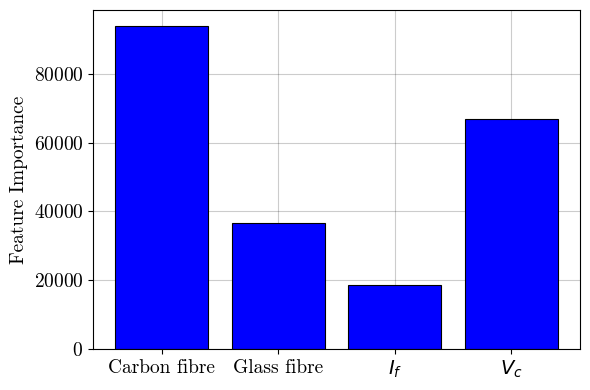

In [5]:
model = sm
X = X_tr
feature_names = [
    r'Carbon fibre', 
    r'Glass fibre', 
    r'$I_{f}$', 
    r'$V_{c}$', 
    ]

feature_importance = PDFeatureImportanceDisplay.from_surrogate_model(
    model, 
    X_tr, 
    feature_names=feature_names, 
    sorted=False,
    ratio_samples=0.01,
    grid_resolution=20,
    figsize=[6, 4]
)

In [91]:
import numpy as np
from scipy.stats.mstats import mquantiles

class PartialDependenceDisplay:
    def __init__(
            self, 
            pd_results, 
            *, 
            features, 
            deciles, 
            feature_names, 
            is_categorical,
            random_state = None
            ):
        self.pd_results = pd_results
        self.features = features
        self.deciles = deciles
        self.feature_names = feature_names
        self.is_categorical = is_categorical
        self.random_state = random_state
        

    @classmethod
    def from_surrogate_model(
            cls,
            model,
            X,
            features,
            *,
            sample_weight=None,
            categorical_features=None,
            feature_names=None,
            percentiles=(0.05, 0.95),
            grid_resolution=100,
            kind="average", 
            centered = False,
            ratio_samples = None,
            inverse_categories_map = None,
    ):
        pd_results = partial_dependence(
            model, 
            X, 
            features, 
            sample_weight=sample_weight, 
            categorical_features=categorical_features, 
            percentiles=percentiles, 
            grid_resolution=grid_resolution, 
            kind=kind, 
            ratio_samples=ratio_samples,
            inverse_categories_map = inverse_categories_map,
            )

        target_features = set()
        for feature in features:
            if type(feature) is int:
                target_features.add(feature)
            else:
                for f in feature:
                    target_features.add(f)

        is_categorical = [0] * X.shape[1]
        if categorical_features is not None:
            for feature_index in categorical_features:
                is_categorical[feature_index] = 1

        deciles = {}
        for feature in target_features:
            if is_categorical[feature] == 0:
                deciles[feature] = mquantiles(
                    X[:, feature], 
                    prob=np.arange(0.1, 1.0, 0.1)
                    )
            
        display = PartialDependenceDisplay(
            pd_results, 
            features = features, 
            deciles = deciles,
            feature_names = feature_names,
            is_categorical=is_categorical,
            )
        return display.plot(
            centered=centered,
        )

    def _plot_ice_lines(
        self,
        categorical,
        preds,
        feature_values,
        n_ice_to_plot,
        ax,
        pd_plot_idx,
        n_total_lines_by_plot,
        individual_line_kw
    ):
        if self.random_state is None:
            rng = np.random.mtrand._rand
        else:
            rng = np.random.RandomState(self.random_state)
        if categorical:
            medianprops = {
                'color': 'black',
            }
            boxprops = {
                # 'facecolor': 'white',
                'facecolor': 'None',
            }
            values = []
            for i in range(preds.shape[1]):
                values.append(preds[:, i])
            ax.boxplot(
                values,
                patch_artist=True, 
                medianprops=medianprops,
                boxprops=boxprops,
                )
        else:
            # subsample ICE
            ice_lines_idx = rng.choice(
                preds.shape[0],
                n_ice_to_plot,
                replace=False
            )
            ice_lines_subsampled = preds[ice_lines_idx, :]
            # plot the subsampled ICE
            for ice_idx, ice in enumerate(ice_lines_subsampled):
                # line_idx = np.unravel_index(
                #     pd_plot_idx * n_total_lines_by_plot + ice_idx, self.lines_.shape
                # )
                # self.lines_[line_idx] = ax.plot(
                #     feature_values, ice.ravel(), **individual_line_kw
                # )[0]
                ax.plot(feature_values[0], ice.ravel(), **individual_line_kw)
            # individual_line_kw_label = individual_line_kw
            # individual_line_kw_label['label'] = "ICE"
            # ax.plot([], [], **individual_line_kw_label)

    def _plot_average_dependence(
        self, 
        categorical,
        kind_plot,
        avg_preds,
        feature_values,
        ax,
        pd_line_idx,
        line_kw
    ):
        # print(avg_preds, categorical, kind_plot)
        if categorical:
            if kind_plot == "both":
                ax.scatter(
                    np.arange(1, len(avg_preds)+1), 
                    avg_preds,
                    color="blue",
                    label='Average',
                )
            else:
                ax.bar(
                    np.arange(1, len(avg_preds)+1), 
                    avg_preds,
                    color="blue", 
                    edgecolor='black', 
                    linewidth=0.8,
                )
                ax.set_xticks(np.arange(1, len(avg_preds)+1))
        else:
            ax.plot(
                feature_values[0], 
                avg_preds,
                **line_kw
            )

    def _plot_one_way_partial_dependence(
        self, 
        kind, 
        categorical,
        preds,
        avg_preds,
        feature_values, 
        feature_categories,
        feature_idx, 
        n_ice_lines,
        ax,
        n_cols, 
        plot_idx, 
        n_lines, 
        ice_lines_kw,
        pd_line_kw,
        bar_kw, 
        pdp_lim
    ):
        from matplotlib import transforms

        if kind in ["individual", "both"]:
            self._plot_ice_lines(
                categorical, 
                preds,
                feature_values,
                n_ice_lines,
                ax,
                plot_idx,
                n_lines,
                ice_lines_kw
            )

        if kind in ("average", "both"):
            # the average is stored as the last line
            if kind == "average":
                pd_line_idx = plot_idx
            else:
                pd_line_idx = plot_idx * n_lines + n_ice_lines
            self._plot_average_dependence(
                categorical,
                kind,
                avg_preds.ravel(),
                feature_values,
                ax,
                pd_line_idx,
                pd_line_kw
            )
        trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
         # create the decile line for the vertical axis
        vlines_idx = np.unravel_index(plot_idx, self.deciles_vlines_.shape)
        if self.deciles.get(feature_idx, None) is not None:
            self.deciles_vlines_[vlines_idx] = ax.vlines(
                self.deciles[feature_idx],
                0,
                0.05,
                transform=trans,
                color="k",
            )
        # reset ylim which was overwritten by vlines
        pass
        # min_val = min(val[0] for val in pdp_lim.values())
        # max_val = max(val[1] for val in pdp_lim.values())
        # ax.set_ylim([min_val, max_val])
        if kind in ["individual", "both"]:
            max_val = preds.max()
            min_val = preds.min()
        else:
            max_val = avg_preds.max()
            min_val = avg_preds.min()
        max_val = max_val + 0.05 * (max_val-min_val)
        min_val = min_val - 0.05 * (max_val-min_val)
        ax.set_ylim([min_val, max_val])

        # Set xlabel if it is not already set
        # if not ax.get_xlabel():
        #     ax.set_xlabel(self.feature_names[feature_idx])
        if self.feature_names is None:
            ax.set_xlabel(fr'$x_{feature_idx}$', fontsize=14)
        else:
            ax.set_xlabel(self.feature_names[feature_idx], fontsize=14)
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)

        if n_cols is None or plot_idx % n_cols == 0:
            if not ax.get_ylabel():
                ax.set_ylabel("Partial dependence", fontsize=14)
                # ax.set_ylabel(r"$y$", fontsize=14)
        else:
            # ax.set_yticklabels([])
            pass
        
        if categorical:
            ax.set_xticklabels(feature_categories[0])
        # if pd_line_kw.get("label", None) and kind != "individual" and not categorical:
        #     ax.legend()
        if kind == "both":
            ax.legend(
                loc = 'upper left', 
                fontsize = 12,
            )
        ax.grid(
            color = 'black',
            alpha = 0.2,
            )
        
    
    def _plot_two_way_partial_dependence(
            self,
            kind,
            categorical,
            avg_preds,
            feature_values,
            feature_categories,
            feature_idx,
            ax,
            Z_level,
            contour_kw,
            heatmap_kw
    ):
        if kind == "individual":
            pass
        else:
            if categorical:
                # default_im_kw = dict(interpolation="nearest", cmap="viridis")
                default_im_kw = dict(interpolation="nearest", cmap="Blues")
                im_kw = {**default_im_kw, **heatmap_kw}

                data = avg_preds
                im = ax.imshow(data, **im_kw)
                text = None
                cmap_min, cmap_max = im.cmap(0), im.cmap(1.0)

                text = np.empty_like(data, dtype=object)
                # print text with appropriate color depending on background
                thresh = (data.max() + data.min()) / 2.0

                for flat_index in range(data.size):
                    row, col = np.unravel_index(flat_index, data.shape)
                    color = cmap_max if data[row, col] < thresh else cmap_min
                    # color = 'black'
                    values_format = ".1e"
                    text_data = format(data[row, col], values_format)

                    text_kwargs = dict(ha="center", va="center", color=color)
                    text[row, col] = ax.text(col, row, text_data, **text_kwargs)

                fig = ax.figure
                fig.colorbar(im, ax=ax)
                ax.set(
                    xticks=np.arange(len(feature_values[1])),
                    yticks=np.arange(len(feature_values[0])),
                    xticklabels=feature_categories[1],
                    yticklabels=feature_categories[0],
                )
                if self.feature_names is not None:
                    xlabel=self.feature_names[feature_idx[1]]
                    ylabel=self.feature_names[feature_idx[0]]
                else:
                    xlabel = fr'$x_{feature_idx[1]}$'
                    ylabel = fr'$x_{feature_idx[0]}$'
                ax.set_xlabel(xlabel, fontsize=14)
                ax.set_ylabel(ylabel, fontsize=14)

                plt.setp(ax.get_xticklabels(), rotation="vertical")
            else:
                from matplotlib import transforms
                XX, YY = np.meshgrid(feature_values[0], feature_values[1])
                Z = avg_preds.T
                CS = ax.contour(XX, YY, Z, levels=Z_level, linewidths=0.5, colors="k")
                # contour_idx = np.unravel_index(pd_plot_idx, self.contours_.shape)
                ax.contourf(XX, YY, Z, levels=Z_level, vmax=Z_level[-1], vmin=Z_level[0], **contour_kw)
                ax.clabel(CS, fmt="%2.2f", colors="k", fontsize=12, inline=True)

                trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
                # create the decile line for the vertical axis
                xlim, ylim = ax.get_xlim(), ax.get_ylim()
                ax.vlines(
                    self.deciles[feature_idx[0]],
                    0,
                    0.05,
                    transform=trans,
                    color="k",
                )
                # create the decile line for the horizontal axis
                ax.hlines(
                    self.deciles[feature_idx[1]],
                    0,
                    0.05,
                    transform=trans,
                    color="k",
                )
                # reset xlim and ylim since they are overwritten by hlines and
                # vlines
                ax.set_xlim(xlim)
                ax.set_ylim(ylim)
                if self.feature_names is None:
                    ax.set_xlabel(fr'$x_{feature_idx[0]}$', fontsize=14)
                    ax.set_ylabel(fr'$x_{feature_idx[1]}$', fontsize=14)
                else:
                    ax.set_xlabel(self.feature_names[feature_idx[0]], fontsize=14)
                    ax.set_ylabel(self.feature_names[feature_idx[1]], fontsize=14)
                ax.xaxis.set_tick_params(labelsize=12)
                ax.yaxis.set_tick_params(labelsize=12)
            
    def plot(
        self, 
        *,
        n_cols=3, 
        ax = None,
        line_kw=None,
        ice_lines_kw=None,
        pd_line_kw=None,
        contour_kw=None,
        bar_kw=None,
        heatmap_kw=None,
        centered = False,
        pdp_lim = None,
        max_num_ice_lines = 250,
    ):
        import matplotlib.pyplot as plt  
        from matplotlib.gridspec import GridSpecFromSubplotSpec 
        # plt.rcParams["axes.formatter.use_mathtext"] = True
        plt.rcParams.update({
            "text.usetex": False,
            "font.family": "serif",
            "font.serif": "cmr10",
            "axes.formatter.use_mathtext": True,
        })

        kind = []
        for pd_result in self.pd_results:
            keys = pd_result.keys()
            if (len(pd_result['grid_values'])>1) & ('average' in keys):
                kind.append('average')
            else:
                if ('average' in keys) and ('individual' in keys):
                    kind.append('both')
                elif ('average' in keys) and ('individual' not in keys):
                    kind.append('average')
                else:
                    kind.append('individual')

        n_results = len(self.pd_results)
        if ax is None:
            _, ax = plt.subplots()

        if not centered:
            pd_results_ = self.pd_results
        else:
            pd_results_ = []
            for kind_plot, pd_result in zip(kind, self.pd_results):
                current_results = {"grid_values": pd_result["grid_values"]}

                if "grid_categories" in pd_result:
                    current_results["grid_categories"] = pd_result["grid_categories"]

                if kind_plot in ("individual", "both"):
                    preds = pd_result["individual"]
                    preds = preds - preds[:, 0, None]
                    current_results["individual"] = preds

                if kind_plot in ("average", "both"):
                    avg_preds = pd_result["average"]
                    avg_preds = avg_preds - avg_preds[0, None]
                    current_results["average"] = avg_preds

                pd_results_.append(current_results)

        if pdp_lim is None:
            pdp_lim = {}
            for kind_plot, pd_result in zip(kind, pd_results_):
                values = pd_result["grid_values"]
                preds = pd_result["average"] if kind_plot == "average" else pd_result["individual"]
                min_pd = preds.min()
                max_pd = preds.max()

                # expand the limits to account so that the plotted lines do not touch
                # the edges of the plot
                span = max_pd - min_pd
                min_pd -= 0.05 * span
                max_pd += 0.05 * span

                n_features = len(values)
                old_min_pd, old_max_pd = pdp_lim.get(n_features, (min_pd, max_pd))
                min_pd = min(min_pd, old_min_pd)
                max_pd = max(max_pd, old_max_pd)
                pdp_lim[n_features] = (min_pd, max_pd)

        contains_categories = []
        for feature in self.features:
            if type(feature) is int:
                contains_categories.append(self.is_categorical[feature])
            else:
                contains_categories_ = [self.is_categorical[f] for f in feature]
                contains_categories.append(np.max(contains_categories_)==1)
        
        if line_kw is None:
            line_kw = {}
        if ice_lines_kw is None:
            ice_lines_kw = {}
        if pd_line_kw is None:
            pd_line_kw = {}
        if bar_kw is None:
            bar_kw = {}
        if heatmap_kw is None:
            heatmap_kw = {}
        if contour_kw is None:
            contour_kw = {}
        default_contour_kws = {"alpha": 0.75}
        contour_kw = {**default_contour_kws, **contour_kw}

        is_average_plot = [kind_plot == "average" for kind_plot in kind]
        if all(is_average_plot):
            # only average plots are requested
            n_ice_lines = 0
            n_lines = 1
        else:
            # we need to determine the number of ICE samples computed
            ice_plot_idx = is_average_plot.index(False)
            n_ice_lines = pd_results_[ice_plot_idx]["individual"].shape[0]
            n_ice_lines = min(n_ice_lines, max_num_ice_lines)
            
            if any([kind_plot == "both" for kind_plot in kind]):
                n_lines = n_ice_lines + 1  # account for the average line
            else:
                n_lines = n_ice_lines

        if isinstance(ax, plt.Axes):
            ax.set_axis_off()
            self.bounding_ax_ = ax
            self.figure_ = ax.figure

            n_cols = min(n_cols, n_results)
            n_rows = int(np.ceil(n_results / float(n_cols)))
            self.axes_ = np.empty((n_rows, n_cols), dtype=object)
            self.figure_.set_size_inches(n_cols * 7, n_rows * 5)

            axes_ravel = self.axes_.ravel()

            gs = GridSpecFromSubplotSpec(
                n_rows, n_cols, subplot_spec=ax.get_subplotspec()
            )
            for i, spec in zip(range(n_results), gs):
                axes_ravel[i] = self.figure_.add_subplot(spec)

        # create contour levels for two-way plots
        if 2 in pdp_lim:
            Z_level = np.linspace(*pdp_lim[2], num=8)
        self.deciles_vlines_ = np.empty_like(self.axes_, dtype=object)
        self.deciles_hlines_ = np.empty_like(self.axes_, dtype=object)

        for plot_idx, (axi, pd_result, kind_plot, feature_idx, cat) in enumerate(
            zip(
                self.axes_.ravel(),
                pd_results_, 
                kind, 
                self.features,
                contains_categories,
            )
        ):
            # print(feature_idx)
            avg_preds = None
            preds = None
            feature_values = pd_result["grid_values"]
            feature_categories = None
            if cat:
                feature_categories = pd_result["grid_categories"]

            if kind_plot == "individual":
                preds = pd_result["individual"]
            elif kind_plot == "average":
                avg_preds = pd_result["average"]
            else: # kind_plot == "both"
                preds = pd_result["individual"]
                avg_preds = pd_result["average"]
            
            if len(feature_values) == 1:
                # define the line-style for the current plot
                # default_line_kws = {
                #     "color": "C0",
                #     "label": "average" if kind_plot == "both" else None,
                # }
                default_line_kws = {
                    "color": "C0",
                    "label": "Average" if kind_plot == "both" else None,
                }
                if kind_plot == "individual":
                    default_ice_lines_kws = {
                        "alpha": 0.3, 
                        "linewidth": 0.5, 
                        }
                    default_pd_lines_kws = {}
                elif kind_plot == "both":
                    # by default, we need to distinguish the average line from
                    # the individual lines via color and line style
                    default_ice_lines_kws = {
                        "alpha": 0.3,
                        "linewidth": 0.5,
                        "color": "tab:gray",
                        "label": r"ICE"
                    }
                    default_pd_lines_kws = {
                        "color": "blue",
                        "linestyle": "--",
                        "linewidth": 2.5,
                        "label": r"Average"
                    }
                else:
                    default_ice_lines_kws = {}
                    default_pd_lines_kws = {
                        "color": "blue",
                        "linewidth": 2.5,
                    }

                ice_lines_kw = {
                    **default_line_kws,
                    **default_ice_lines_kws,
                    **line_kw,
                    **ice_lines_kw,
                }
                del ice_lines_kw["label"]

                pd_line_kw = {
                    **default_line_kws,
                    **default_pd_lines_kws,
                    **line_kw,
                    **pd_line_kw,
                }

                default_bar_kws = {"color": "C0"}
                bar_kw = {**default_bar_kws, **bar_kw}

                default_heatmap_kw = {}
                heatmap_kw = {**default_heatmap_kw, **heatmap_kw}

                self._plot_one_way_partial_dependence(
                    kind_plot, 
                    cat,
                    preds,
                    avg_preds,
                    feature_values, 
                    feature_categories,
                    feature_idx, 
                    n_ice_lines,
                    axi,
                    n_cols, 
                    plot_idx, 
                    n_lines, 
                    ice_lines_kw,
                    pd_line_kw,
                    bar_kw, 
                    pdp_lim
                )
                
            else:
                self._plot_two_way_partial_dependence(
                    kind_plot,
                    cat,
                    avg_preds,
                    feature_values,
                    feature_categories,
                    feature_idx,
                    axi,
                    Z_level,
                    contour_kw,
                    heatmap_kw
                )

        return self

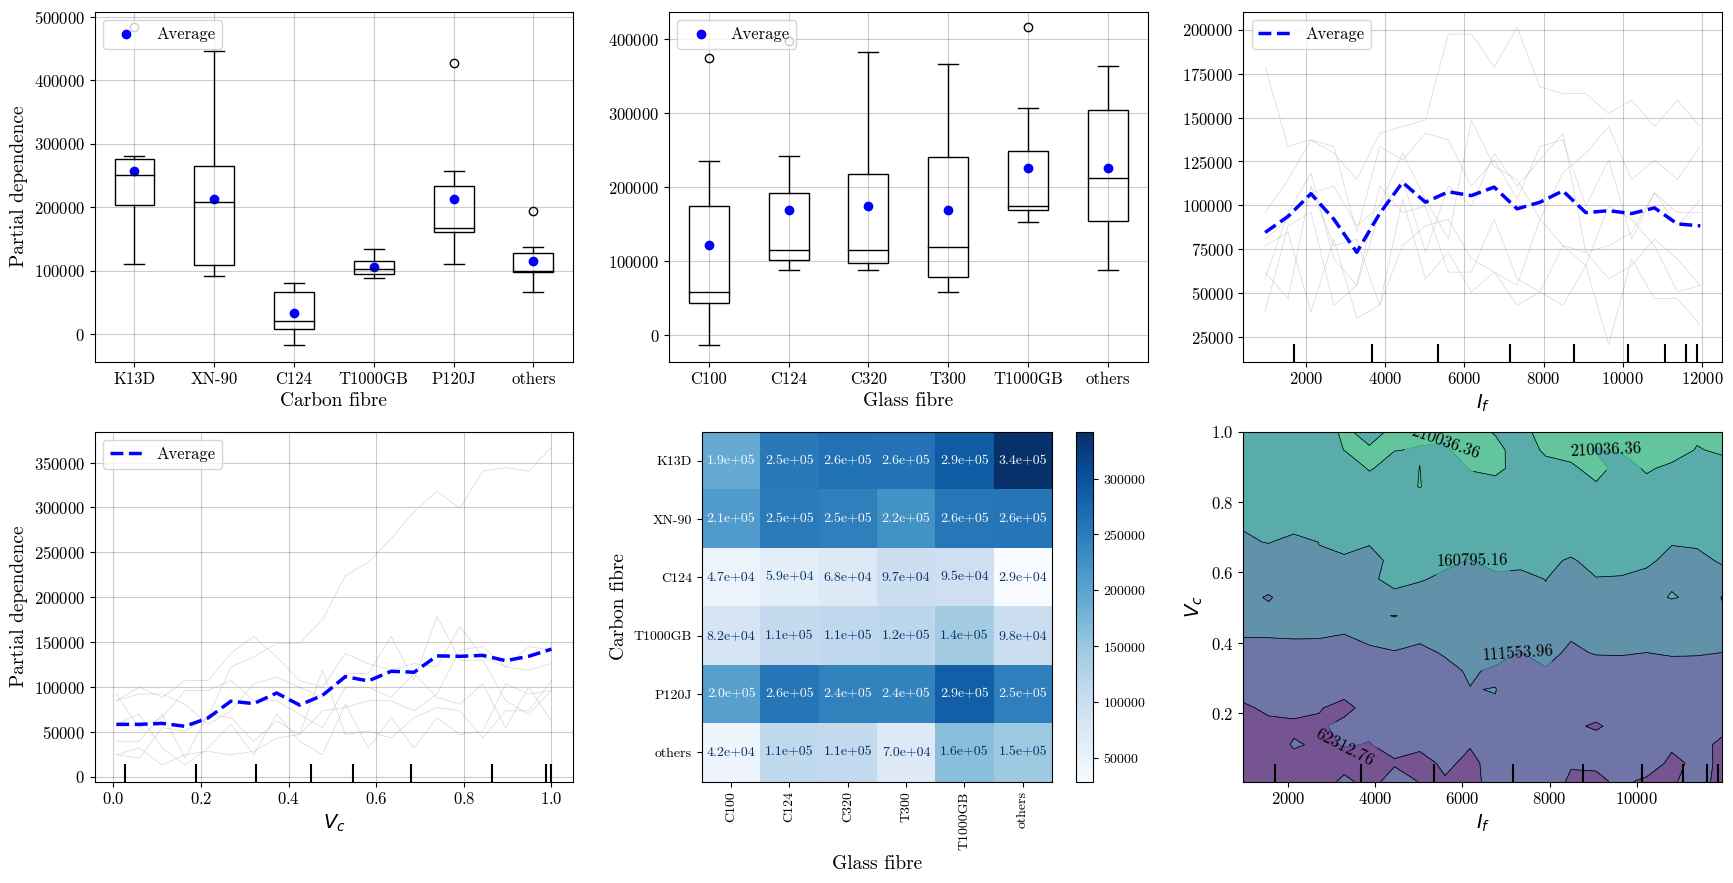

In [92]:
model = sm
X = X_tr
feature_names = [
    r'Carbon fibre', 
    r'Glass fibre', 
    r'$I_{f}$', 
    r'$V_{c}$', 
    ]

features = [0, 1, 2, 3, (0, 1), (2, 3)]
categorical_features = [0, 1]

pdd = PartialDependenceDisplay.from_surrogate_model(
    model, 
    X, 
    features, 
    categorical_features=categorical_features, 
    feature_names=feature_names,
    grid_resolution=20,
    kind='both',
    ratio_samples = 0.01,
    inverse_categories_map=categories_inverse_map,
    centered=False,
    )

In [82]:
test_number = 100000
print(f'{test_number:03.2f}')

100000.00


In [53]:
pdd.pd_results[0]['average']

array([156122.88870937, 135698.50133697,  53463.46796911,  90012.37168816,
       161497.72749159,  70125.46819397])

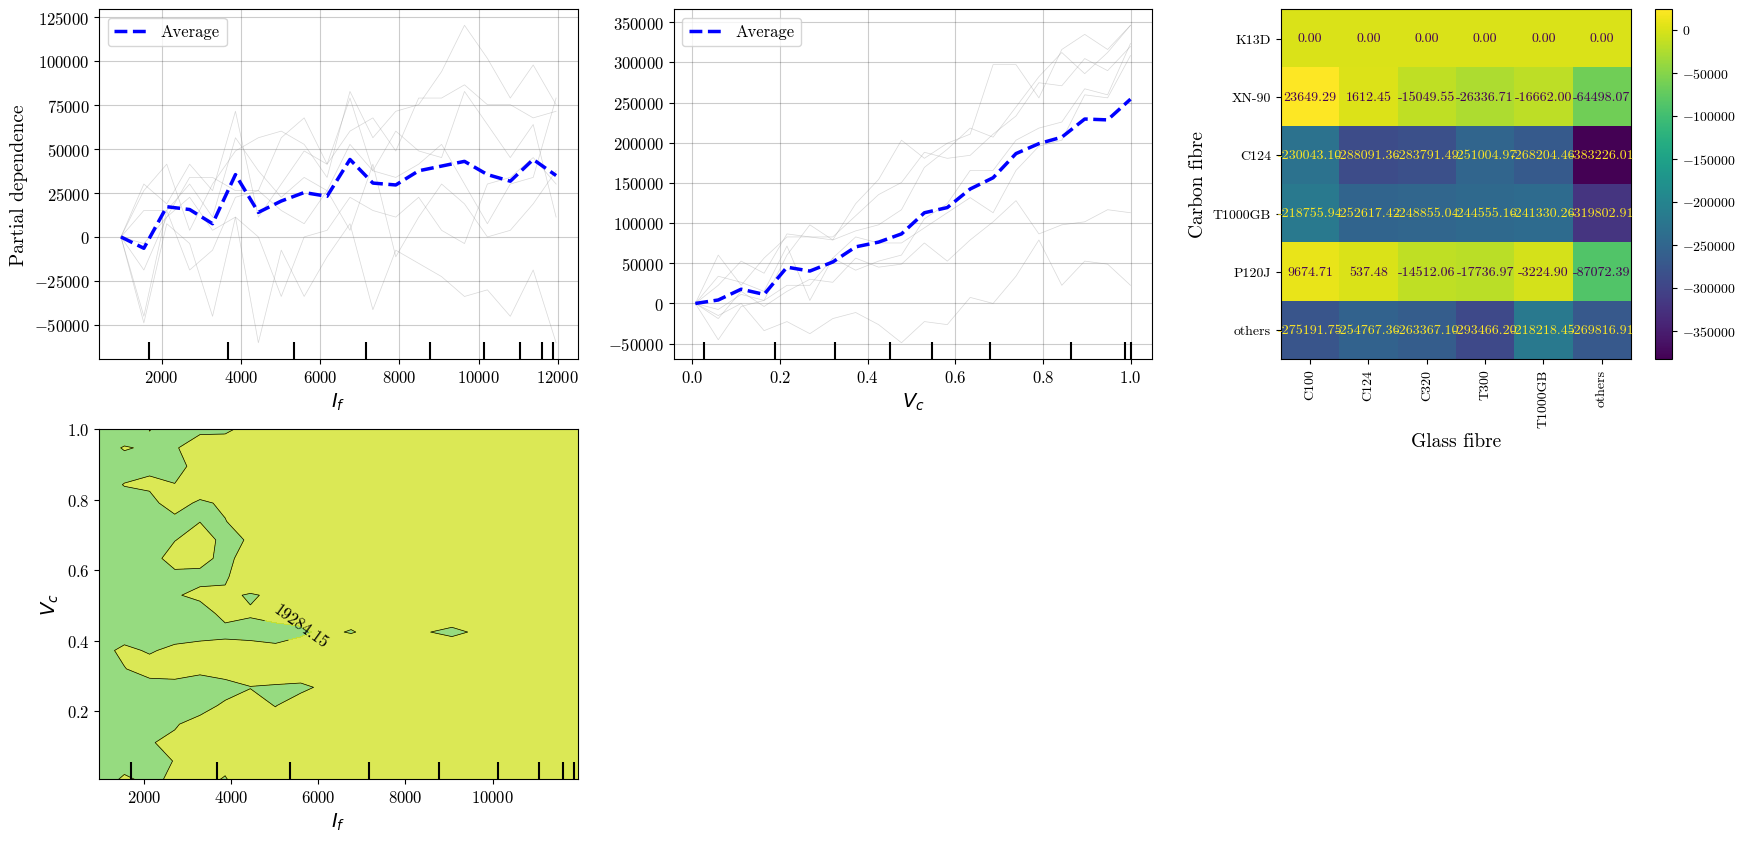

In [22]:
model = sm
X = X_tr
# features = [0, 1, 2, 3, (0, 1), (2, 3)]
feature_names = [
    r'Carbon fibre', 
    r'Glass fibre', 
    r'$I_{f}$', 
    r'$V_{c}$', 
    ]

features = [2, 3, (0, 1), (2, 3)]
categorical_features = [0, 1]

pdd = PartialDependenceDisplay.from_surrogate_model(
    model, 
    X, 
    features, 
    categorical_features=categorical_features, 
    feature_names=feature_names,
    grid_resolution=20,
    kind='both',
    ratio_samples = 0.01,
    inverse_categories_map=categories_inverse_map,
    centered=True
    )

In [30]:
model = sm
X = X_tr
features = [0, 1, 2, 3, (0, 1), (2, 3)]
features = [(0, 1)]
categorical_features = [0, 1]

pd_results = partial_dependence(
    model, 
    X, 
    features, 
    categorical_features=categorical_features, 
    grid_resolution=20,
    kind='both',
    ratio_samples = 0.01,
    inverse_categories_map=categories_inverse_map,
    )

[1, 1] True


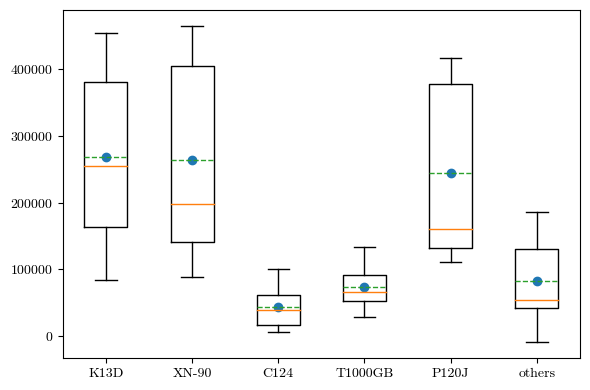

In [34]:
fig, ax = plt.subplots(1, 1, figsize=[6, 4])
values = []
for i in range((pd_results[0]['individual']).shape[1]):
    values.append(pd_results[0]['individual'][:, i])
ax.boxplot(values, meanline=True, showmeans=True)
ax.set_xticklabels(pd_results[0]['grid_categories'][0])

ax.scatter(pd_results[0]['grid_values'][0]+1, pd_results[0]['average'])
fig.tight_layout()

In [39]:
np.arange(1, )

array([1, 2, 3, 4])

In [20]:
pd_results[0]

{'grid_values': [array([0., 1., 2., 3., 4., 5.])],
 'grid_categories': [array(['K13D', 'XN-90', 'C124', 'T1000GB', 'P120J', 'others'], dtype='<U7')],
 'average': array([268457.01925762, 263082.1804754 ,  43251.27428291,  73887.85534152,
        243732.76085944,  81950.11351484]),
 'individual': array([[137310.95297163, 107211.85579124,  24439.33854517,
          58300.82287311, 129786.17867653,  43251.27428291],
        [253944.95454564, 174934.82444712,   9389.78995497,
          65825.5971682 , 133548.56582408, 144835.72726673],
        [189984.37303731, 197509.14733241,  39488.88713536,
          47013.66143046, 159885.27585692,  39488.88713536],
        [351767.02038191, 393153.27900495,  99687.08149614,
         103449.46864369, 374341.3432672 ,  54538.43572556],
        [453351.47336573, 464638.63480837,  69587.98431575,
         133548.56582408, 381866.1175623 , 186221.98588976],
        [408202.82759514, 415727.60189024,  54538.43572556,
          80875.1457584 , 415727.6018902

In [19]:
pd_results[0]['individual'].shape

(7, 6)